In [1]:
import pandas as pd
import numpy as np
import torch
import random

## Setup

In [2]:
df_train = pd.read_csv("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/train_set.csv")
df_test = pd.read_csv("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/test_set.csv")
weights_25 = torch.load("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/estimations/weights.pt")
bias_25 = torch.load("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/estimations/bias.pt")


/tmp/ipykernel_3828512/2155574885.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_25 = torch.load("../../data/instruction-induction-data/datamodels/datamodels_06

In [3]:
weights = weights_25.detach().numpy()
bias = bias_25.detach().numpy()

In [4]:
weights.shape

(315, 3885)

In [5]:
df_test["weights"] = list(weights)   
df_test["bias"] = list(bias)


## A1: Show tasks by sample for top weights

In [6]:
from analysis_toolkit import *

In [7]:
df_test["estimation_task"] = df_test["weights"].apply(lambda indices: [df_train.loc[i, "task"] for i in range(len(indices))])


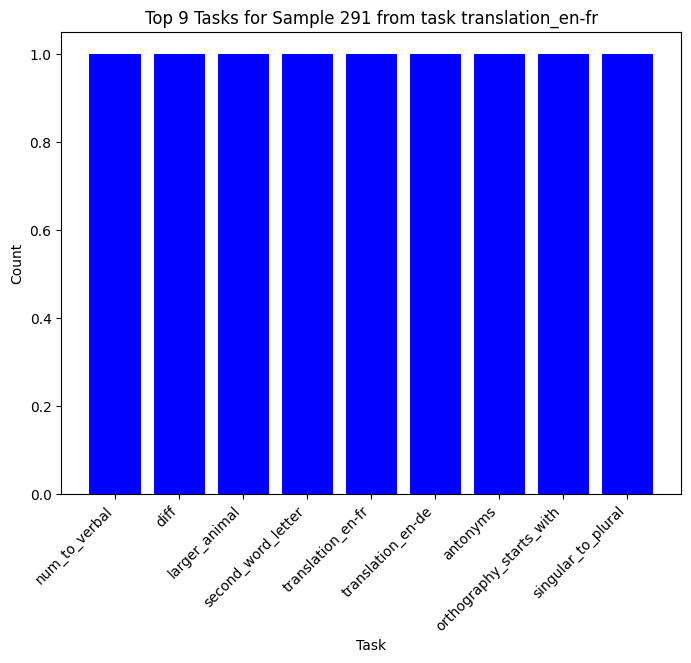

array([1401,  542,  749, 1912, 3518, 3177,  339, 1610, 2454])

In [8]:
sample = random.randint(0, 315)
top_k = random.randint(3, 10)
show_tasks_by_sample(df_test, sample, top_k)

In [9]:
compare_i_most_high_samples(df_test, df_train, sample, 1)

Sample 291 input: corporation
Sample 291 output: corporation
1 Most influential input: 5927
1 Most influential output: five thousand, nine hundred and twenty-seven


In [10]:
compare_i_most_high_samples(df_test, df_train, sample, 2)

Sample 291 input: corporation
Sample 291 output: corporation
2 Most influential input: 96 14
2 Most influential output: 82


In [11]:
compare_i_most_high_samples(df_test, df_train, sample, 3)

Sample 291 input: corporation
Sample 291 output: corporation
3 Most influential input: great white shark, toy poodle
3 Most influential output: great white shark


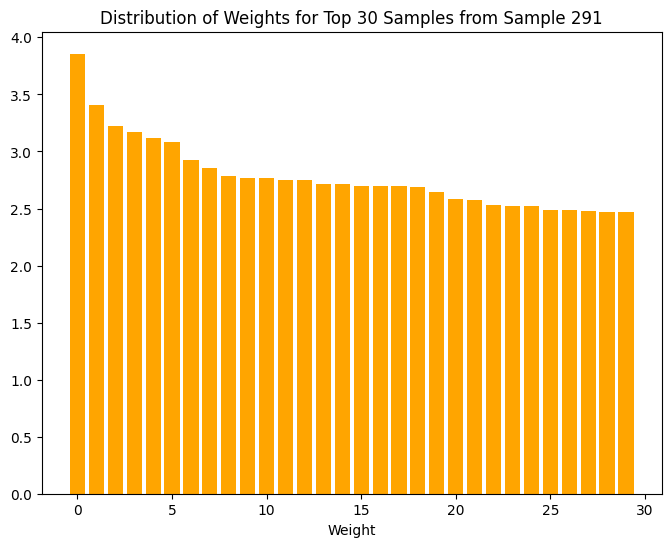

In [12]:
plot_hist_weights(df_test, 30, sample)

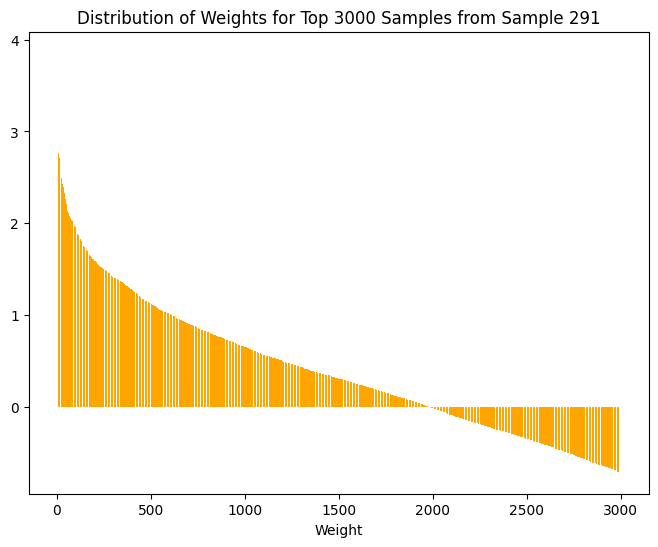

In [13]:
plot_hist_weights(df_test, 3000, sample)

## A2: Analysis by Category

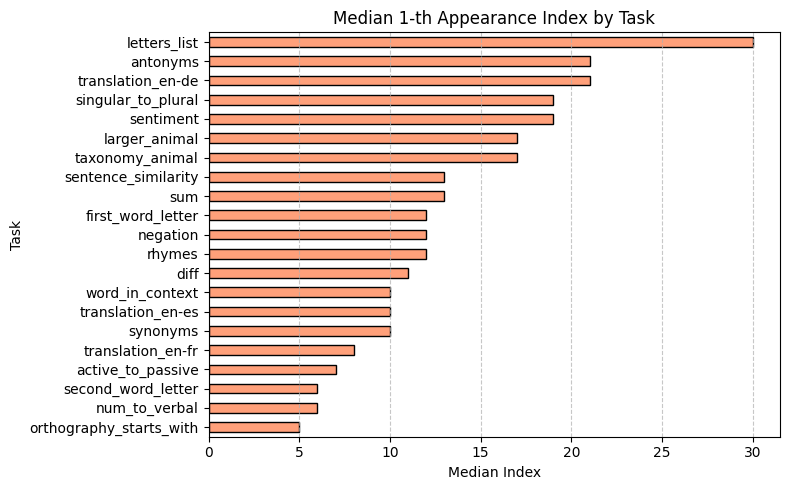

In [14]:
median_category_i_appeareance(df_test, 1)

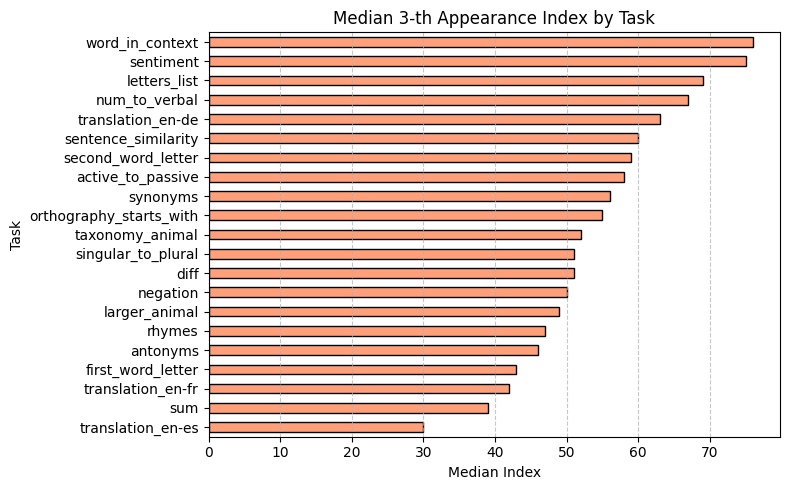

In [17]:
median_category_i_appeareance(df_test, 3)

## A3: Linear Models Evaluation

In [ ]:
from src.datamodels.evaluator import LinearRegressorEvaluator
from pathlib import Path
import torch
import pandas as pd

weights = torch.load("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/estimations/weights.pt")
bias = torch.load("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/estimations/bias.pt")



# Directory containing your files
directory = Path("../../data/instruction-induction-data/datamodels/datamodels_06_11_2024/collections")

# List all files starting with "test_"
files = list(directory.glob("test_*"))

# Combine all files into a single DataFrame
df_list = [pd.read_pickle(file) for file in files]
combined_df = pd.concat(df_list, ignore_index=True)

if torch.cuda.is_available():
    torch.set_default_device("cuda")

/tmp/ipykernel_25026/653104249.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("../../data/instruction-induction-data/datamodels/datamodels_06_11_20

In [4]:
combined_df

,collection_idx,test_idx,input,evaluation
0,40,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.777778
1,40,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.555556
2,40,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.444444
3,40,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.714286
4,40,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.400000
...,...,...,...,...
46930,119,310,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
46931,119,311,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.500000
46932,119,312,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.666667
46933,119,313,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.222222
